# The Business Problem and My Approach

Fitbod is a fitness app that creates a daily and deeply personalized workout routine by analyzing tracked workout data. It has been popular among people who love working out. However, Fitbod also faces customer attrition problem. Thus, it is important to predict which customer is going to churn out and take marketing strategies such as sending emails that promote the product or offering incentives to prevent them from churning out. In the following analyses, based on customers' activity records, I will build a prediction model that predicts which customers will be churning out.

# Key Findings

1. I first looked at the average interval of two subsequent workouts of each customer. I discovered that 87% of them have an interval of less than two weeks. Based on this finding, I define customers who haven't had any workout for more than 14 days as churned customers; 

2. I then looked at the usage of the 14-day period for churned and active customers; I found that the average number of exercises done by active customers is about 19.3, almost two times that of churned customers. Clearly the two groups of customers differ from each other a lot in terms of usage and thus usage within the 14-day period can be used as predictors of churn; 

3. Also, I suspected that active and churned customers have different preferences for muscle groups. I looked at the number of exercises done for each muscle groups by active and churned customers. The average numbers of back and quadricep exercises done by active customers are much more than that of churned customers, which indicates that the number of exercises done to improve different muscle groups are also informative of determining churn.

4. Based on the discoveries from the above exploratory analysis, I use the number of exercises done on each day in the previous 14 days as well as the total number of exercises done for each muscle group to predict whether a customer will churn out on the eleventh day. After tuning parameters and comparing performances of algorithms, I chose decision tree to build the model. The model can identify 93% of the actual churned customers.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from scipy import stats
import warnings
import graphviz
# 
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, \
                            precision_score, recall_score, f1_score, accuracy_score, \
                            roc_curve, auc

# Data

## Reading in and Inspecting the dataset

In [2]:
data = pd.read_csv('fitbod_OuWenzhe_20200807-195605.csv')

In [3]:
data.shape

(25267, 8)

In [4]:
data.head()

,Date,workoutId,exerciseId,singleSetId,exerciseName,reps,weight,fake_user_id
0,2018-09-19,L9WbPdYFrx,h85ZOw37Wc,YVZTbtgZNL,Dumbbell Bench Press,5,24.947610,fake_id_361
1,2020-01-09,wib0nC1A5I,G1mxtZtEs5,y1nAkrqupp,Back Squat,5,80.000000,fake_id_358
2,2019-07-12,u9LKojOiBd,h85ZOw37Wc,KmN8uwpHPB,Dumbbell Bench Press,12,22.679645,fake_id_417
3,2019-11-21,XWcgCyJBBj,mvkMgAdecH,OBPOCsPvc3,Dumbbell Shoulder Press,10,18.143716,fake_id_404
4,2020-02-08,rAxB3SPhhB,52vo7F7CLd,F3nOvbxhDD,Close-Grip Bench Press,7,55.000000,fake_id_358


We have a dataset that has information about each workout of customers, including the date, the type of exercises, reps, weight.

In [5]:
data = data.sort_values(by=['fake_user_id','Date'])

In [6]:
# Coverting Date variable to datetime type
data['Date'] = pd.to_datetime(data['Date'])

In [7]:
data['exerciseName'].unique()

array(['Back Squat', 'Barbell Bench Press', 'Deadlift',
       'Dumbbell Shoulder Press', 'Close-Grip Bench Press',
       'Dumbbell Bent Over Row', 'Dumbbell Lunge', 'Dumbbell Row',
       'Dumbbell Bench Press'], dtype=object)

There are 9 types of exercises.

In [8]:
data['fake_user_id'].nunique()

101

There are 101 customers

## Checking null values

In [9]:
data.isnull().sum() / data.shape[0]

Date            0.0
workoutId       0.0
exerciseId      0.0
singleSetId     0.0
exerciseName    0.0
reps            0.0
weight          0.0
fake_user_id    0.0
dtype: float64

There are no null value in this dataset.

### Excluding customers who had fewer than 3 workouts

In this analysis, I only considered customers who had more than three workouts; Those customers are those who have converted and within the range of churning-out analysis; As for customers who had fewer than 3 workouts, they are probably new customers. They should be considered when we are doing landing analysis;

In [10]:
# Excluding customers who have fewer than 3 workouts
d1 = pd.DataFrame(data.groupby('fake_user_id')['workoutId'].nunique()).reset_index()
irrelevant_ids = d1[d1['workoutId']<=3]['fake_user_id']
data=data[data['fake_user_id'].isin(irrelevant_ids)==False]

In [11]:
data['fake_user_id'].nunique()

96

There are 96 customers left in the dataset;

## Feature Engineering

When doing exercises, people always have a target muscle groups, so besides just having the exercises names, I'd like to see which muscle group the customers are actually working on.

In [12]:
dictionary = {
    'Dumbbell Bench Press':'Chest', 'Back Squat':'Quadricep', 'Dumbbell Shoulder Press':'Shoulders',
       'Close-Grip Bench Press':'Tricep', 'Barbell Bench Press':'Chest', 'Deadlift':'Quadricep',
       'Dumbbell Lunge':'Quadricep', 'Dumbbell Bent Over Row':'Back', 'Dumbbell Row':'Back'
}

In [13]:
data['Muscles'] = data['exerciseName'].map(dictionary)

As the analysis will not be using weight and reps variables, I didn't inspect these variables; But if I am doing an analysis where I will be using these variables, I will use boxplots to look at their distributions and remove outliers.

# Exploratory Analysis

## Interval between activities of customers

In this analysis, I will be looking at the average time interval between two workouts of a customer. The motivation for doing this analysis is: to see when is the appropriate time for Fitbod to take actions; If I discover that the majority of customers have a time interval shorter than X days, then if a customer is not using the app for a period longer than X days, it is very likely that the customers will not be using the app anymore and churn out;

In [14]:
# Calculating the time interval between workouts for each customer
data2 = data.groupby('fake_user_id')['Date'].apply(lambda x:(x-x.shift(1)))
data2 = pd.DataFrame(data2)
data2['fake_user_id'] = data['fake_user_id']

In [15]:
# Excluding irrelevant data points
data2 = data2[(data2['Date']!='0 days')&(data2['Date'].isnull()==False)]

In [16]:
# Getting the number of days between workouts
data2['Date'] = data2['Date'].astype('str').str.split(n=1,expand=True)[0].astype('int64')

In [17]:
# Calculating the average time interval for each customer and see the percentage of different time intervals
eda1 = data2.groupby('fake_user_id')['Date'].mean().astype('int64').value_counts().sort_index()/ data['fake_user_id'].nunique()
eda1 = pd.DataFrame(eda1.reset_index())
eda1['Date'] = eda1['Date'] * 100
eda1 = eda1.rename(columns={'index':'Day','Date':'Percentage'})

In [18]:
eda1.to_csv('fitbod_eda1.csv')

In [19]:
# Nearly 87.5% of customers have an average interval of fewer than 14 days
eda1[eda1['Day']<=14]['Percentage'].sum()

87.5

We can see that 87.5% of customers have an average gap of equal to or fewer than 14 days. Based on this finding, we can say that if a customer hasn't have any workout for a more than 14 days interval, it is very likely he will never come back and has churned out; Thus, I define a customer who doesn't have any activity for more than 14 days as churned customers; 

## Usage of churned customers and active customers

Customer activity usage is often a big indicator of churning. And the above analysis shows that a time period of 14 days is important in determing whether a customer will churn or not. In the following analysis, I will look at the workout usage of churned and active customers in a 14-day period. 

### To do that, I need to do data engineering first...

### Finding out churned customers

Today is 2020/8/7. I'll define customers whose latest activity record is before 2020/7/24 to be churned customers and customers whose whose latest activity record is after 2020/7/24 to be active customers.

In [20]:
# Not churn vs Churn: 1:3.5
data_grouped_1 = data.groupby('fake_user_id')['Date'].max()>='2020-07-24'
active_user_ids = data_grouped_1[data_grouped_1==True].index
churned_user_ids = data_grouped_1[data_grouped_1==False].index

In [21]:
n_active = len(active_user_ids)

In [22]:
n_active

21

In [23]:
n_churned = len(churned_user_ids)

In [24]:
n_churned

75

There are 21 active customers and 75 churned customers.

Getting the records of 14 days before the latest activity record for each customer

In [25]:
data_grouped = pd.DataFrame(data.groupby('fake_user_id')['Date'].max().reset_index())
data_grouped = data_grouped.rename(columns={'Date':'Max_Date'})

In [26]:
data_grouped.head()

,fake_user_id,Max_Date
0,fake_id_351,2020-08-07
1,fake_id_352,2020-07-15
2,fake_id_353,2019-12-29
3,fake_id_354,2020-06-22
4,fake_id_355,2020-01-13


In [27]:
# Getting work out frequency of each muscle group for each customer
exercises = pd.DataFrame(data.groupby(['fake_user_id','Date','Muscles']).size().reset_index())
exercises = exercises.rename(columns={0:'times'})

In [28]:
exercises = exercises.merge(data_grouped)

In [29]:
exercises['Max_Date'] = pd.to_datetime(exercises['Max_Date'])
exercises['Date'] = pd.to_datetime(exercises['Date'])

In [30]:
# Getting the last 14 days' activities
exercises = exercises[(exercises['Max_Date'] - exercises['Date']).dt.days<=14]
exercises.head()

,fake_user_id,Date,Muscles,times,Max_Date
235,fake_id_351,2020-07-24,Quadricep,3,2020-08-07
236,fake_id_351,2020-07-28,Quadricep,10,2020-08-07
237,fake_id_351,2020-07-29,Chest,4,2020-08-07
238,fake_id_351,2020-07-30,Quadricep,3,2020-08-07
239,fake_id_351,2020-08-01,Quadricep,4,2020-08-07


In [31]:
# Determining active status of each customer
exercises['Churn'] = np.where(exercises['fake_user_id'].isin(active_user_ids),0,1)

In [32]:
exercises['Day'] = 14 - (exercises['Max_Date'] - exercises['Date']).dt.days

In [33]:
# for imputing records
group = exercises.groupby('fake_user_id')['Date'].nunique()
ids_14 = group[group==1].index

In [34]:
ids_14_churn = churned_user_ids[churned_user_ids.isin(ids_14)]
ids_14_active = active_user_ids[active_user_ids.isin(ids_14)]

In [35]:
# Getting the total usage of churned customers
churned_usage = pd.DataFrame(exercises[(exercises['Churn']==1)&(exercises['Day']<14)].groupby('fake_user_id')['times'].sum().value_counts().sort_index()).reset_index()
df2 = pd.DataFrame([[0,len(ids_14_churn)]], columns=['index','times'])
churned_usage = pd.concat([churned_usage,df2])
churned_usage = churned_usage.rename(columns={'index':'exercises'})

In [36]:
# Getting the average number of exercises churned customers have done in the previous 14 days
avg_churned = (churned_usage['times'] * churned_usage['exercises']).sum() / n_churned

In [37]:
# Getting the total usage of active customers
active_usage = pd.DataFrame(exercises[(exercises['Churn']==0)&(exercises['Day']<14)].groupby('fake_user_id')['times'].sum().value_counts().sort_index()).reset_index()
df2 = pd.DataFrame([[0,len(ids_14_active)]], columns=['index','times'])
active_usage = pd.concat([active_usage,df2])
active_usage = active_usage.rename(columns={'index':'exercises'})

In [38]:
# Getting the average number of exercises active customers have done in the previous 14 days
avg_active = (active_usage['times'] * active_usage['exercises']).sum() / n_active

In [39]:
avg_usage_df = pd.DataFrame({'Customer Type':['Active','Churned'],
                             'Average Usage':[avg_active,avg_churned]})

In [40]:
avg_usage_df

,Customer Type,Average Usage
0,Active,19.523810
1,Churned,9.813333


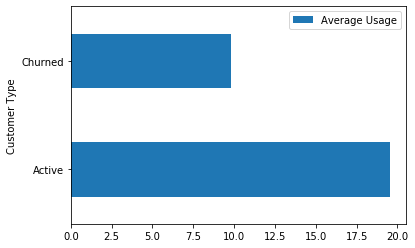

In [66]:
avg_usage_df.plot.barh(x='Customer Type',y='Average Usage')

In [42]:
# Besides plotting them out, I want to do a statistical t-test to see if they are statistically different from each other
churned_df = pd.DataFrame(exercises[(exercises['Churn']==1)&(exercises['Day']<14)].groupby('fake_user_id')['times'].sum()).reset_index()
churned_df2 = pd.DataFrame({'fake_user_id':ids_14_churn,'times':0})
churned_df = pd.concat([churned_df,churned_df2])

active_df = pd.DataFrame(exercises[(exercises['Churn']==0)&(exercises['Day']<14)].groupby('fake_user_id')['times'].sum()).reset_index()
active_df2 = pd.DataFrame({'fake_user_id':ids_14_active,'times':0})
active_df = pd.concat([active_df,active_df2])

In [43]:
stats.ttest_ind(churned_df['times'], active_df['times'], equal_var = False)

Ttest_indResult(statistic=-2.6559128443478355, pvalue=0.013715217578322156)

p-value is very small. The numbers of exercises done by these two groups are statistically significant different.

We can see that the average number of exercises an active customer has done in the previous 14 days is 19.5 while that of a churned customer is 9.8; The average number of exercises of an active customer is almost twice as many as that of a churned customer; Also, the t-test shows these two groups are statistically significant different in terms of their workout frequency. We can see that active customers differ from churned customers in usage a lot. And thus the activity usage in the previous 14 days is indicative of churn;

There is also another practical reason for using the previous 14 days information. Updating the model and taking actions towards churned customers bi-weekly is more timely and accurate than monthly and less costly than daily. 

### Types of muscle groups active customers and churned customers have been working on

In the following analysis, I will be looking at the average number of exercises active and churned customers have done to work on different muscle groups; The intuition of looking at this feature is Fitbod offering recommendation on reps, sets and weight. It is likely that for people who are working on certain muscle groups, recommendations is much more effective than working alone and thus this type of people will have have less chance of churning out.  

In [44]:
# Pivoting table
exercises_1 = exercises.pivot_table(index=['fake_user_id', 'Day'], columns='Muscles', values='times', fill_value=0).reset_index()

In [45]:
# imputing missing days among active days when there is no usage information
exercises_1['next_day'] = exercises_1.groupby('fake_user_id')['Day'].apply(lambda x:x.shift(-1))
exercises_1['next_day'] = exercises_1['next_day'].fillna(0)
exercises_1['next_day'] = exercises_1['next_day'].astype("int64")

In [46]:
muscles_n = data['Muscles'].nunique()

In [47]:
muscles = data['Muscles'].unique()

In [48]:
r = exercises_1[(exercises_1['next_day'] - exercises_1['Day'] > 1)&(exercises_1['next_day']!=0)]['fake_user_id'].values
f = exercises_1[(exercises_1['next_day'] - exercises_1['Day'] > 1)&(exercises_1['next_day']!=0)]['Day'].values
t = exercises_1[(exercises_1['next_day'] - exercises_1['Day'] > 1)&(exercises_1['next_day']!=0)]['next_day'].values
left_df = pd.DataFrame(dict(
        fake_user_id=r.repeat(muscles_n*(t - f - 1)),
        Day=np.concatenate([np.repeat(np.arange(f+1, t),muscles_n) for f, t in zip(f, t)]),
        Muscles=np.concatenate([list(muscles)*(t-f-1) for f, t in zip(f, t)]),
        times=0
    ))

In [49]:
left_df = left_df.pivot_table(index=['fake_user_id', 'Day'], columns='Muscles', values='times', fill_value=0).reset_index()
left_df = left_df.rename_axis(None, axis="columns")
left_df.head()

,fake_user_id,Day,Back,Chest,Quadricep,Shoulders,Tricep
0,fake_id_351,1,0,0,0,0,0
1,fake_id_351,2,0,0,0,0,0
2,fake_id_351,3,0,0,0,0,0
3,fake_id_351,7,0,0,0,0,0
4,fake_id_351,9,0,0,0,0,0


In [50]:
one_records = pd.DataFrame(exercises_1.groupby('fake_user_id').size()==1).reset_index()
one_records_ids = one_records[one_records[0]==True]['fake_user_id']

In [51]:
# Imputing records of customers who didn't work out for the 14 days before their latest active day
imputed_df = pd.DataFrame(dict(fake_user_id=np.repeat(list(one_records_ids),14),
                               Day=list(range(14))*len(one_records_ids),
                               Back=list([0])*14*len(one_records_ids),
                               Chest=list([0])*14*len(one_records_ids),
                               Quadricep=list([0])*14*len(one_records_ids),
                               Shoulders=list([0])*14*len(one_records_ids),
                               Tricep=list([0])*14*len(one_records_ids)))

In [52]:
imputed_df.head()

,fake_user_id,Day,Back,Chest,Quadricep,Shoulders,Tricep
0,fake_id_354,0,0,0,0,0,0
1,fake_id_354,1,0,0,0,0,0
2,fake_id_354,2,0,0,0,0,0
3,fake_id_354,3,0,0,0,0,0
4,fake_id_354,4,0,0,0,0,0


In [53]:
exercises_1 = exercises_1.drop('next_day',axis=1)
df = pd.concat([left_df,exercises_1,imputed_df])
df = df.sort_values(by=['fake_user_id','Day'])

In [54]:
# Getting the sum of exercises of each muscle group
df1 = df[df['Day']!=14].groupby('fake_user_id').sum()[['Back', 'Chest', 'Quadricep', 'Shoulders', 'Tricep']].reset_index()

In [55]:
df2 = df.set_index(['fake_user_id','Day']).sum(axis=1).reset_index().rename(columns={0:'times'})

In [56]:
df2 = df2[df2['Day']!=14].pivot_table(index=['fake_user_id'], columns='Day', values='times', fill_value=0).reset_index()
df2 = df2.merge(df1)
df2.head()

,fake_user_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,Back,Chest,Quadricep,Shoulders,Tricep
0,fake_id_351,3,0,0,0,10,4,3,0,4,0,0,11,6,0,0,10,31,0,0
1,fake_id_352,0,0,8,0,0,4,0,0,0,0,0,0,0,0,4,0,8,0,0
2,fake_id_353,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,4,0,0
3,fake_id_354,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,fake_id_355,0,0,0,0,0,0,0,8,0,0,4,0,0,0,4,4,4,0,0


In [57]:
df2['churn'] = np.where(df2['fake_user_id'].isin(active_user_ids),0,1)

In [58]:
df2.head()

,fake_user_id,0,1,2,3,4,5,6,7,8,...,10,11,12,13,Back,Chest,Quadricep,Shoulders,Tricep,churn
0,fake_id_351,3,0,0,0,10,4,3,0,4,...,0,11,6,0,0,10,31,0,0,0
1,fake_id_352,0,0,8,0,0,4,0,0,0,...,0,0,0,0,4,0,8,0,0,1
2,fake_id_353,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,4,0,0,1
3,fake_id_354,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,fake_id_355,0,0,0,0,0,0,0,8,0,...,4,0,0,0,4,4,4,0,0,1


In [59]:
df2.groupby('churn')[['Back','Chest','Quadricep','Shoulders','Tricep']].mean()

,Back,Chest,Quadricep,Shoulders,Tricep
churn,,,,,
0,5.190476,4.238095,7.142857,2.333333,0.619048
1,1.466667,3.000000,3.013333,1.440000,0.893333


We can see that the average number of back exercises active customers has done is about 4 times that of churned customers; For quadricep, the average number of exercises active customers has done is more than 2 times that of churned customers; But for chest, shoulders, the difference is not that large and for tricep, it shows that the average number of exercises done by churned customers is even higher than that of the active customers; Remember, the above analysis has shown that the average number of exercises active customers has done is twice that of churned customers. Based on the results of these two analyses, we can see that the active customers tend to do more quadricep and back exercises; Clearly, the types of muscle groups customers have been working on is informative in determining which customer is going to churn.

The 0-13 columns indicate the total exercises of every day in the previous 14 day period for each customer while the muscle group columns show the total exercises done for different muscle groups; And the churn column indicate the status of each customer; The dataset is ready for model building

# Churn Prediction Model 

## Splitting training and testing sets

In [60]:
y=df2['churn']
X=df2.drop(['churn','fake_user_id'],axis=1)

In [61]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.4,random_state = 42, stratify = y)

## Model Selection

For the following analysis, I will try to build the model based on five commonly seen machine learning algorithms(K nearest neighbour, Logistic Regression, Decision Tree, Support Vector Machine and Random Forest). They can be used in this model building as they are supervised machine learning and predict the labels of test objects.

I will also show the performance of four metrics of models (accuracy, precision, recall, f1); Accuracy measures how correct the models' predictions are; Precision measures out of all predicted churned customers, how many are correctly predicted while recall measures the percentage of actual churned customers the model has successfully identified; As there is tradeoff between precision and recall(one of them could become 0 and makes the other one very high, f1 which is the harmonic mean of the recall and precision is also used in this analysis to show the performance of five models;

Out of four metrics I have used, I mainly use recall as the metric to gauge the performace of classifiers; In a churn problem, it is more important for the model to find out churned customers as many as possible, thus I chose recall.


In [62]:
names = ['KNN','Logistic_regression','Decision_tree','SVC','Random Forest']
classifiers = [KNeighborsClassifier(algorithm='auto'),
               linear_model.LogisticRegression(random_state=42),
               DecisionTreeClassifier(),
               SVC(),
               RandomForestClassifier(random_state=1)]
parameters = {'KNN':{"n_neighbors": range(5,20),
                     "weights": ['uniform','distance']},
              'Logistic_regression': {"C": np.arange(0.5,2.0,0.1)},
              'Decision_tree':{"max_depth": range(3,15),
                               "criterion" : ['gini', 'entropy']},
              'SVC':{'C': np.arange(0.5,10,0.1),
                     'kernel':['rbf', 'linear']},
              'Random Forest':{"max_depth": range(3,15),
                               "criterion" : ['gini', 'entropy']}}

In [63]:
warnings.simplefilter('ignore')
for name, clf in zip(names, classifiers):
    grid_clf = GridSearchCV(clf, parameters[name],cv = 10, scoring='recall')
    grid_clf.fit(X_train, y_train)
    print ('\nname:', name)
    print ('best_params:', grid_clf.best_params_)
    
    # Look at the model with other evaluation metrics
    pred = grid_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred,average='binary')
    recall = recall_score(y_test, pred,average='binary')
    f1 = f1_score(y_test, pred,average='micro')
    
    eval_dict = {'accuracy': accuracy,
                 'precision': precision,
                 'recall': recall,
                 'f1': f1}
    print(confusion_matrix(y_test, pred))
    print(eval_dict)


name: KNN
best_params: {'n_neighbors': 5, 'weights': 'uniform'}
[[ 0  9]
 [ 0 30]]
{'accuracy': 0.7692307692307693, 'precision': 0.7692307692307693, 'recall': 1.0, 'f1': 0.7692307692307693}

name: Logistic_regression
best_params: {'C': 0.5}
[[ 1  8]
 [ 4 26]]
{'accuracy': 0.6923076923076923, 'precision': 0.7647058823529411, 'recall': 0.8666666666666667, 'f1': 0.6923076923076923}

name: Decision_tree
best_params: {'criterion': 'gini', 'max_depth': 4}
[[ 2  7]
 [ 3 27]]
{'accuracy': 0.7435897435897436, 'precision': 0.7941176470588235, 'recall': 0.9, 'f1': 0.7435897435897437}

name: SVC
best_params: {'C': 0.5, 'kernel': 'rbf'}
[[ 0  9]
 [ 0 30]]
{'accuracy': 0.7692307692307693, 'precision': 0.7692307692307693, 'recall': 1.0, 'f1': 0.7692307692307693}

name: Random Forest
best_params: {'criterion': 'entropy', 'max_depth': 3}
[[ 1  8]
 [ 1 29]]
{'accuracy': 0.7692307692307693, 'precision': 0.7837837837837838, 'recall': 0.9666666666666667, 'f1': 0.7692307692307693}


Randorm forest, support vector machines and K-nearest neighbour have good recall scores; However, at the closer look at them, K-nearest neightbour and Support Vector Machine nearly predicts all of the test objects to be churned; This is equal to take marketing strategies towards all customers and thus the model will not be needed; Thus, it is reasonable to use random forest.

Intuitively, random forest is very suited for this problem. First, the previous exploratory analyses have shown that there is great distinction between churned and active customers in terms of the inputted features. Having great distinction can make decision trees which are the components of random forest split nodes easily; Secondly, random forest is an ensemble model made up of random trees. It has improved model performance and less bias than decision tree; One of the biggest cons of decision tree is it is unstable and has high variance. Small changes in the training dataset can lead to big change in the structure of the decision tree. But for random forest, each tree of random forest uses a different subset of features and training data. And it uses majority votes of trees when predicting. Variance can be reduced.

In [64]:
clf = RandomForestClassifier(criterion='entropy', max_depth=3,random_state=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred,average='binary')
recall = recall_score(y_test, pred,average='binary')
f1 = f1_score(y_test, pred,average='micro')
eval_dict = {'accuracy': accuracy,
                 'precision': precision,
                 'recall': recall,
                 'f1': f1}
print(confusion_matrix(y_test, pred))
print(eval_dict)

[[ 1  8]
 [ 1 29]]
{'accuracy': 0.7692307692307693, 'precision': 0.7837837837837838, 'recall': 0.9666666666666667, 'f1': 0.7692307692307693}


In [65]:
features_df = pd.DataFrame({'Features':X.columns,
                            'Importances':clf.feature_importances_})
features_df.sort_values(by='Importances',ascending=False)

,Features,Importances
16,Quadricep,0.313433
14,Back,0.124171
1,1,0.113886
13,13,0.110380
15,Chest,0.100910
4,4,0.051786
9,9,0.040784
18,Tricep,0.039682
12,12,0.030093
7,7,0.028819


We can see that the number of quadricep exercises, the number of back exercises, the number of exercises done on day 2 and 14 are the most important features in determining which customers are going to churn out; The result is also in line with the above exploratory analysis.

# Limitations & Next Step

As the dataset is small, the model is not very robust in predicting churn. 

In the following section, I'll be talking about how I will be building models if I am given a larger dataset.

About churn prediction:
1. If there is more information provided, I will be looking at other information such as the profiles for churned and active groups to see if they are also informative in churn prediction; And if in that case, I have discovered many more features, I'll be doing feature selection or dimensionality reduction.
2. And if in the real dataset, it is likely that the target label is hugely imbalanced. To cope with this problem, I'll take a subset from the data by randomly sampling from active and churned groups so that the ratio of active to churned customers be normal(e.g.one to four); Also, I'll be using AUC to gauge performance of models;

What other analyses can be done with a larger dataset?
1. Association rules analysis; As there are only 5 muscle groups in this small dataset, it doesn't make sense to do association rules analysis; But if the real dataset is provided, I can use association rules analysis to find out the most commonly appeared muscle groups exercises and provide recommendations to customers; For example, I discover that chest, shoulders, and triceps appear together often. Then I can recommend customers who have focused on chest and triceps to also work on shoulders;

2. Clustering analysis; We can also perform clustering analysis on customers based on their usage; This can be used when we are trying to do marketing. We can develop personalized marketing strategies for different segments of customers; For example, for people who work out heavily, we can focus on building muscles; But for people who prefer light workouts, we can focus on staying healthy.


# Conclusion

In this analysis, I have used random forest model to predict customer churn based on the number of exercises done in the previous 14 days and different muscle groups. The model can identify 96% of actual churned customers. However, as the dataset is very small, it is likely that the model is not very robust. 